In [91]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [92]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [93]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
experiment = "Tonsil"
cores=['DonorA', 'DonorE']
# cores = ['B5', 'C6', 'D4', 'E4', 'E6', 'F4', 'F7']
datasets = [f'{core}_{i}' for core in cores for i in range(1,7)]
# datasets = ['E6_1', 'E6_2', 'E6_3']

# Load data

In [95]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [96]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [97]:
adatas = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    data_all = df_intensity_TS.iloc[:, 1:].values
    data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    data_all_norm = MinMaxScaler().fit_transform(data_all_norm)
    df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    adatas.append(adata)
adata = ad.concat(adatas, join="inner")

Sucessfully read dataset DonorA_1
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_4124/4238477812.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_2
normalizing counts per cell
    finished ({time_passed})


C:\Users\thu71\AppData\Local\Temp/ipykernel_4124/4238477812.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_3
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_4124/4238477812.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_4
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_4124/4238477812.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorA_5
normalizing counts per cell
    finished (0:00:00)
DonorA_6 cannot be read


C:\Users\thu71\AppData\Local\Temp/ipykernel_4124/4238477812.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_1
normalizing counts per cell
    finished ({time_passed})


C:\Users\thu71\AppData\Local\Temp/ipykernel_4124/4238477812.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_2
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_4124/4238477812.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_3
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_4124/4238477812.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_4
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_4124/4238477812.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_5
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_4124/4238477812.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset DonorE_6
normalizing counts per cell
    finished ({time_passed})


C:\Users\thu71\AppData\Local\Temp/ipykernel_4124/4238477812.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)
C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [98]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


# Load SIMS

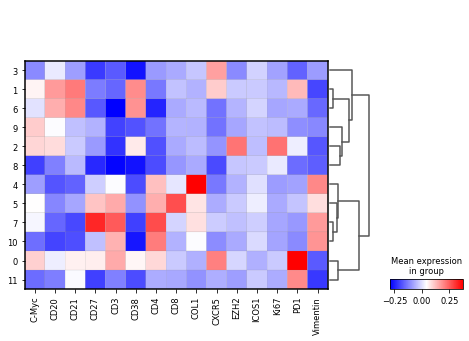

In [99]:
sc.pl.matrixplot(adata_IMC_cluster, adata_IMC_cluster.var_names, groupby='leiden', dendrogram=True, cmap='bwr')

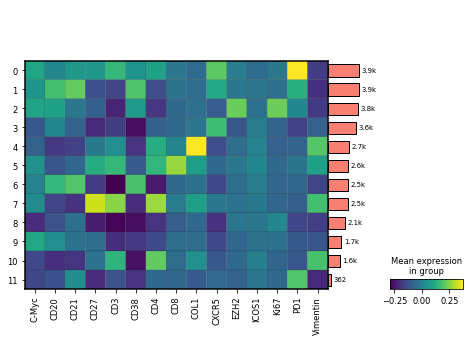

In [100]:
mp = sc.pl.matrixplot(adata_IMC_cluster, adata_IMC_cluster.var_names, groupby='leiden', cmap='bwr', return_fig=True)
mp.add_totals().style(edge_color='black').show()


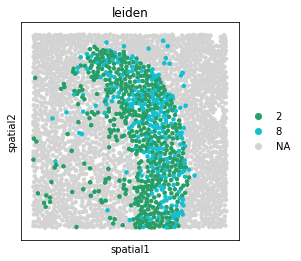

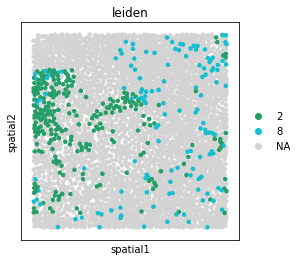

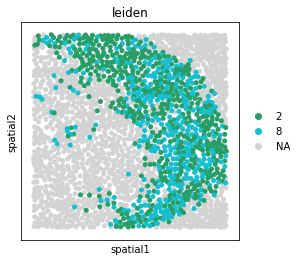

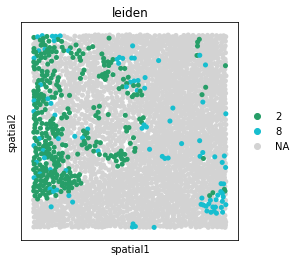

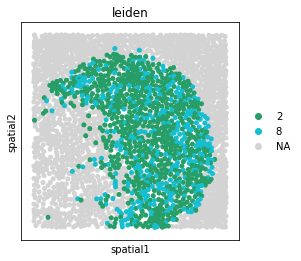

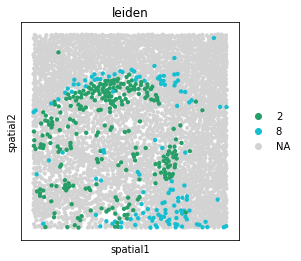

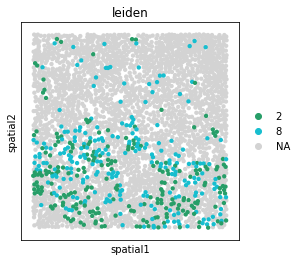

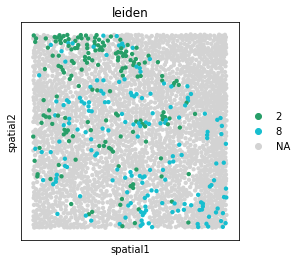

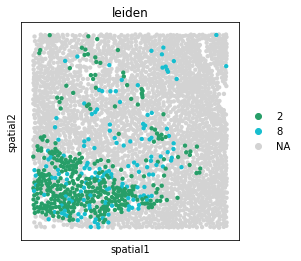

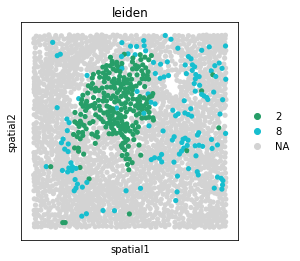

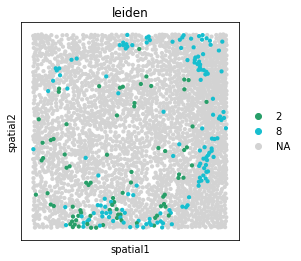

In [101]:
cluster_list = ['2', '8']

for dataset in adata_IMC_cluster.obs['Core'].unique():
    adata_subset = adata_IMC_cluster[adata_IMC_cluster.obs['Core'] == dataset]
    adata_subset.obsm['spatial'] = adata_subset.obsm['spatial'][:,[1,0]]
    sc.pl.spatial(adata_subset, color='leiden', groups=cluster_list , spot_size=10)


In [102]:
adata.obs["leiden"] = adata_IMC_cluster.obs["leiden"]
adata.uns["leiden_colors"] = adata_IMC_cluster.uns["leiden_colors"]
adata.obsm["spatial"] = adata_IMC_cluster.obsm["spatial"]

In [103]:
indices = adata_IMC_cluster.obs['leiden'].isin(cluster_list)
adata_subset = adata[indices, :]

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


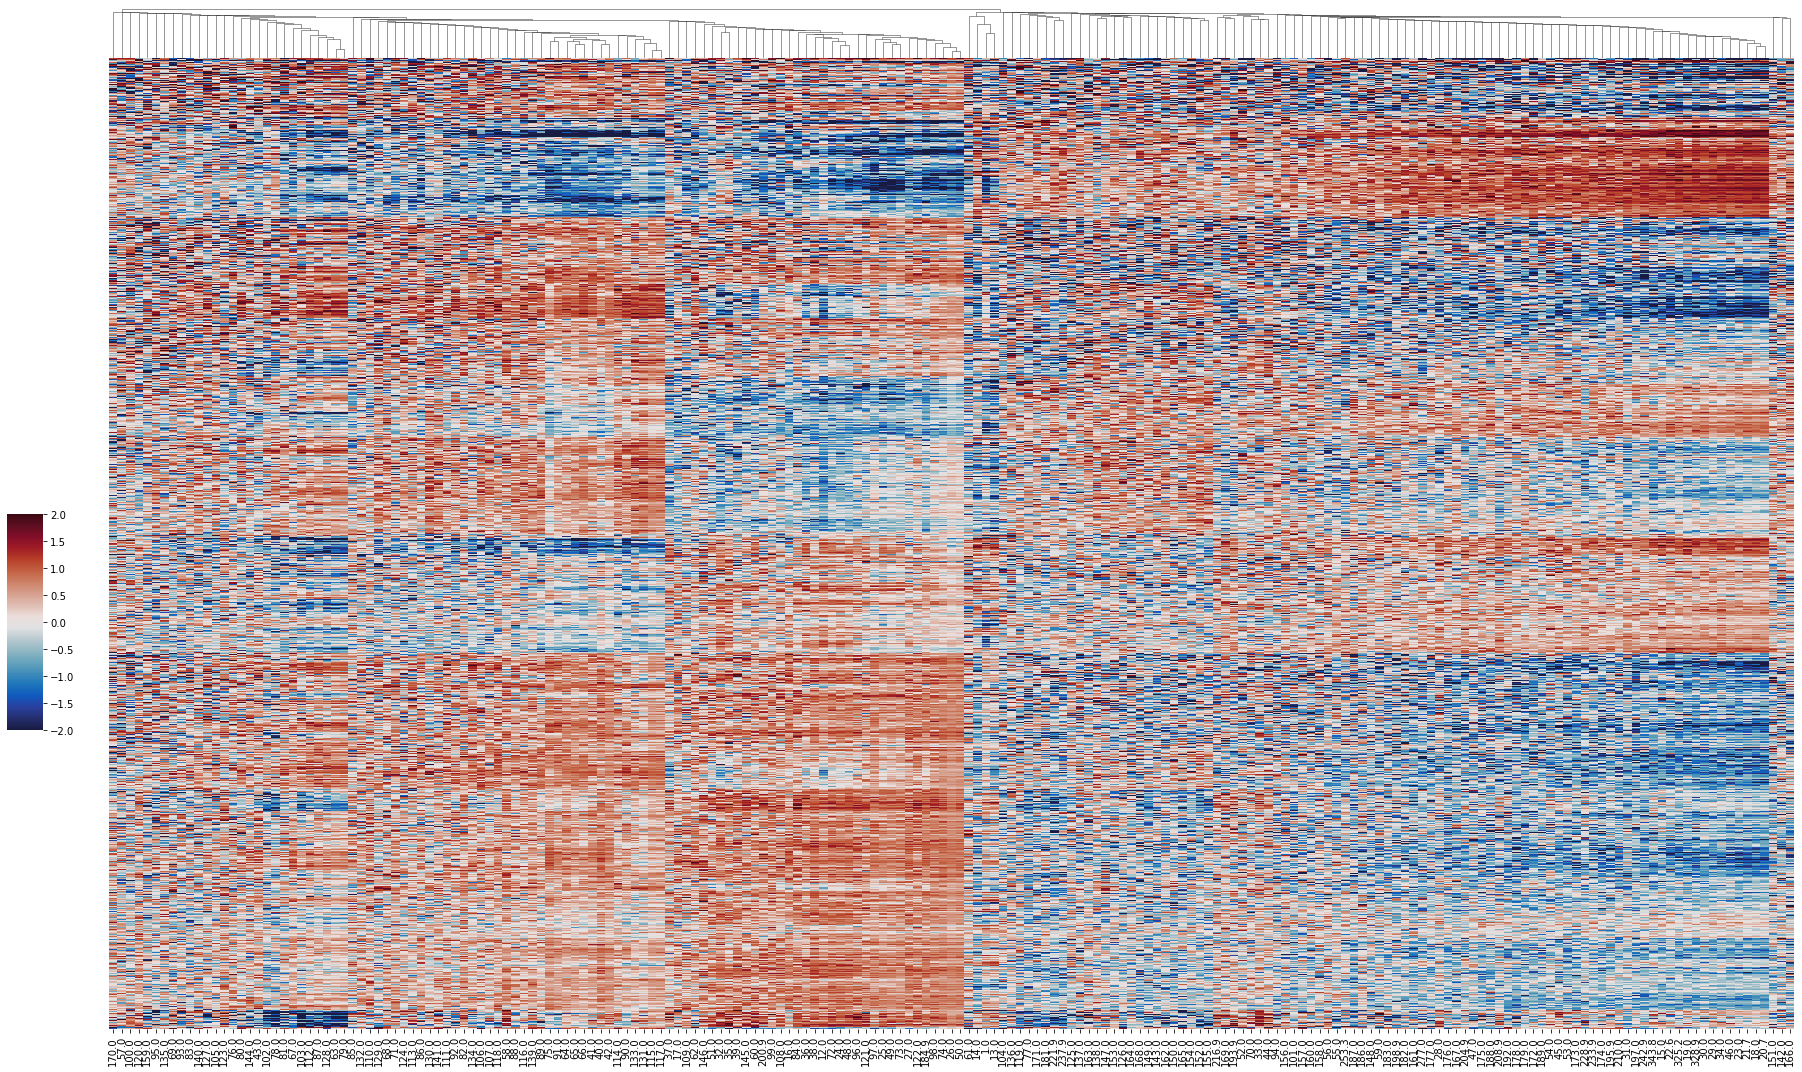

In [104]:
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)

g = sns.clustermap(df_SIMS,
                   cmap=heatmap_cmp,
                   row_cluster=True,
                   col_cluster=True,
                   colors_ratio = (0.01, 0.01),
                   cbar_pos=(.0, .32, .02, .2), 
                   dendrogram_ratio=(.05, .05), 
                   figsize=(25, 15), 
                   yticklabels=False, 
                   xticklabels=True, 
                   vmax=2,
                   vmin=-2)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
g.ax_row_dendrogram.set_visible(False)

plt.show()

In [105]:
sc.pp.neighbors(adata_subset, metric='cosine')
sc.tl.umap(adata_subset)
sc.tl.leiden(adata_subset, resolution=0.5, key_added='cluster_SIMS')


computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)
running Leiden clustering
    finished: found 5 clusters and added
    'cluster_SIMS', the cluster labels (adata.obs, categorical) (0:00:00)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cluster_SIMS']`


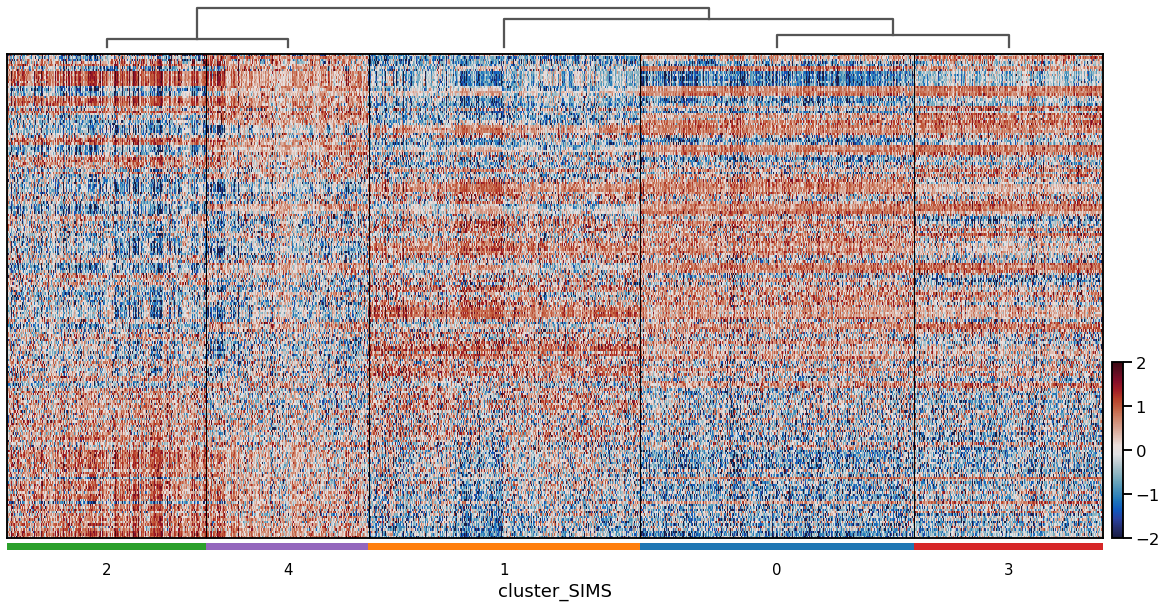

In [106]:
sc.tl.dendrogram(adata_subset, groupby='cluster_SIMS')

with sns.plotting_context("talk", font_scale=1.):
    sc.pl.heatmap(
        adata_subset,
        adata_subset.var_names.tolist(),
        "cluster_SIMS",
        dendrogram=True,
        cmap=heatmap_cmp,
        swap_axes=True, 
        figsize=(20,10),
        vmin=-2,
        vmax=2
    )

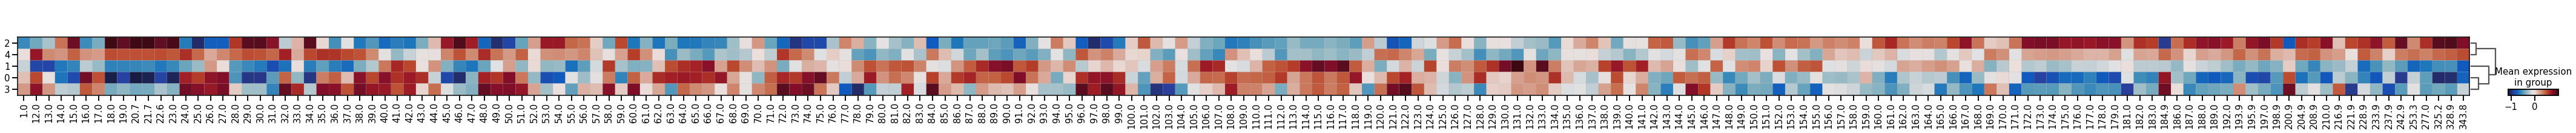

In [107]:
with sns.plotting_context("talk", font_scale=1.):
    sc.pl.matrixplot(
        adata_subset,
        adata_subset.var_names.tolist(),
        "cluster_SIMS",
        dendrogram=True,
        cmap=heatmap_cmp,
        swap_axes=False, 
    )


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cluster_SIMS']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


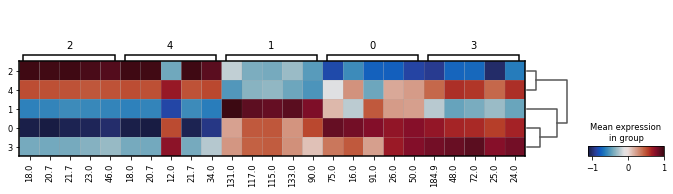

In [108]:
sc.tl.dendrogram(adata_subset, groupby='cluster_SIMS')
sc.tl.rank_genes_groups(adata_subset, groupby='cluster_SIMS', method='t-test')
sc.pl.rank_genes_groups_matrixplot(adata_subset, n_genes=5, use_raw=False, cmap=heatmap_cmp, vmax=1)

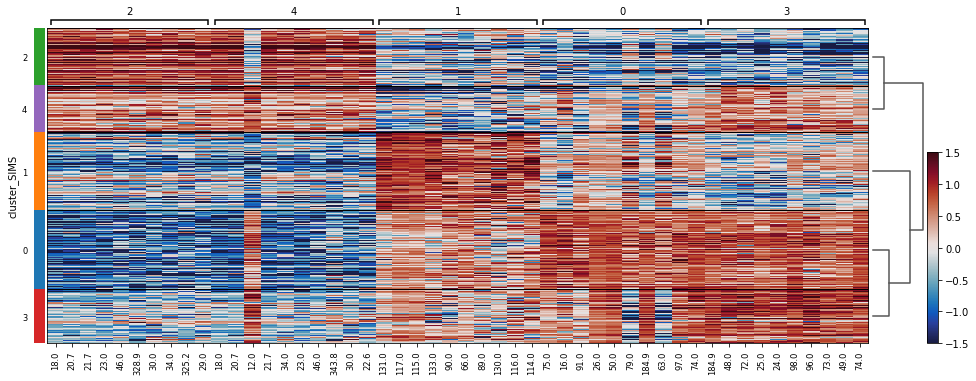

In [109]:
sc.pl.rank_genes_groups_heatmap(adata_subset, groupby='cluster_SIMS',cmap=heatmap_cmp, vmin=-1.5, vmax=1.5, show_gene_labels=True)


# Plot cell mask

In [110]:
from typing import List
import matplotlib
import skimage
from skimage import measure


def get_masks(mask_folder, dataset):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name and dataset in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for i, cells in tqdm(label2cell.items(), total=len(label2cell)):
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]

    return img


def get_contour(mask: np.ndarray) -> List[List[float]]:
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

In [111]:
experiment='tonsil'

In [112]:
masks = get_masks(data_dir / "masks", f"{experiment}")

In [113]:
colors = adata_subset.uns["cluster_SIMS_colors"]
labels = np.unique(adata_subset.obs.cluster_SIMS.tolist())

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

  0%|          | 0/5 [00:00<?, ?it/s]

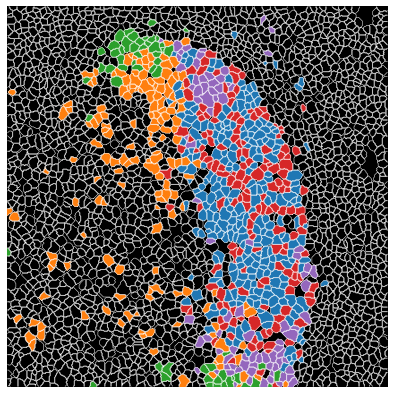

  0%|          | 0/5 [00:00<?, ?it/s]

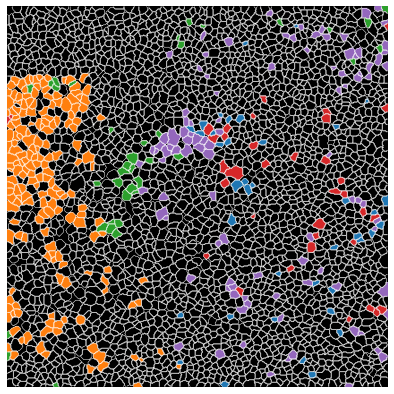

  0%|          | 0/5 [00:00<?, ?it/s]

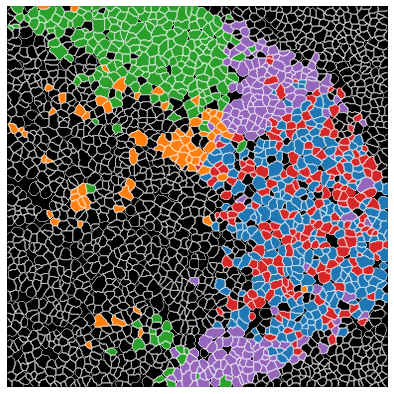

  0%|          | 0/5 [00:00<?, ?it/s]

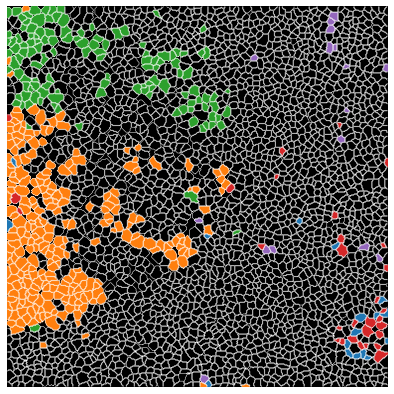

  0%|          | 0/5 [00:00<?, ?it/s]

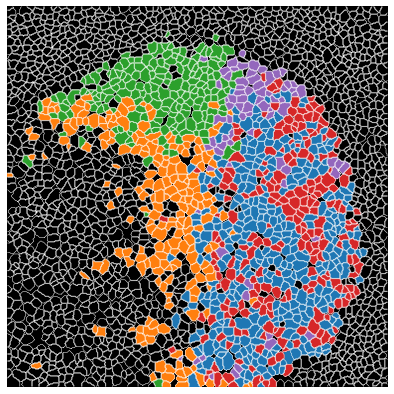

  0%|          | 0/5 [00:00<?, ?it/s]

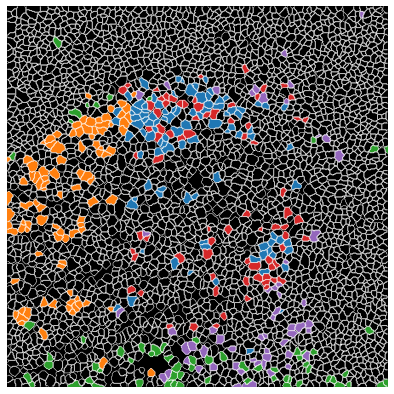

  0%|          | 0/5 [00:00<?, ?it/s]

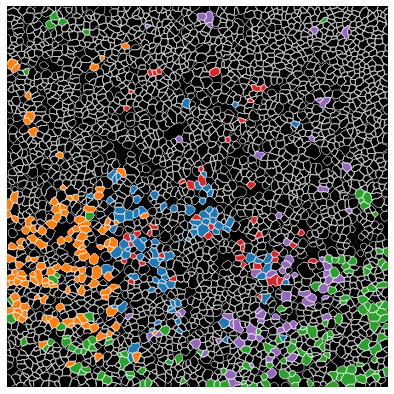

  0%|          | 0/5 [00:00<?, ?it/s]

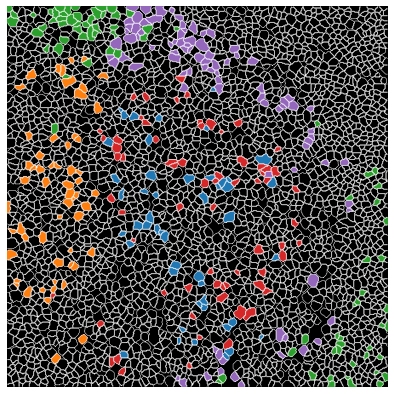

  0%|          | 0/5 [00:00<?, ?it/s]

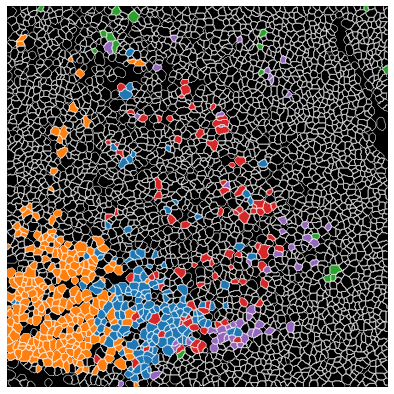

  0%|          | 0/5 [00:00<?, ?it/s]

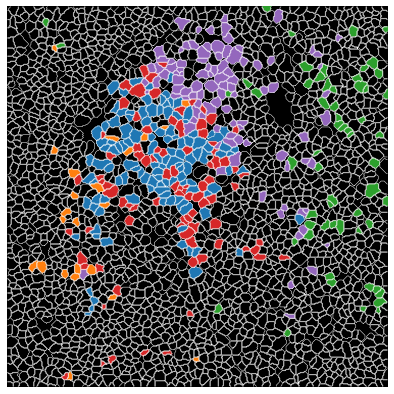

  0%|          | 0/5 [00:00<?, ?it/s]

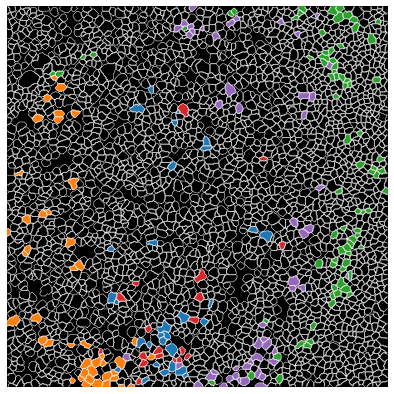

In [114]:
for dataset in adata.obs['Dataset'].unique():
    adata_fov = adata_subset[adata_subset.obs['Dataset'] == dataset]
    try:
        mask = masks["_".join([experiment, dataset])]
        contours = get_contour(mask)
    except:
        print(dataset)
        continue
     # Get label2cell dict
    label2cell = {}
    for l in labels:
        cell_id = adata_fov[adata_fov.obs.cluster_SIMS == l].obs.Cell.to_list()
        label2cell[l] = cell_id

    img = create_clustered_cell(mask, label2cell, colors_rgb)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="white")
    ax.axis("off")
    plt.show()


In [115]:
# for dataset in adata.obs['Dataset'].unique():
#     adata_fov = adata_subset[adata_subset.obs['Dataset'] == dataset]
#     adata_fov.obsm['spatial'] = adata_fov.obsm['spatial'][:,[1,0]]
#     sc.pl.spatial(adata_fov, color='cluster_SIMS', spot_size=10)


## Literature Lut

In [60]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_05052022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()
SIMS_masses = np.array(adata.var_names.to_list())

# get matched table by looking at difference with error
error = 0.5
matched_dfs = []
for mz in SIMS_masses.astype(float):
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
        
matched = pd.concat(matched_dfs)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [61]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)

SIMS_nm_subset = SIMS_masses_subset + 'm/z ' + SIMS_name_subset

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 43


In [62]:
# Get SIMS data
adata_SIMS = adata_subset[:, SIMS_masses_subset]
adata_SIMS.var_names = SIMS_nm_subset
df_SIMS = pd.DataFrame(adata_SIMS.X, columns=SIMS_nm_subset)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


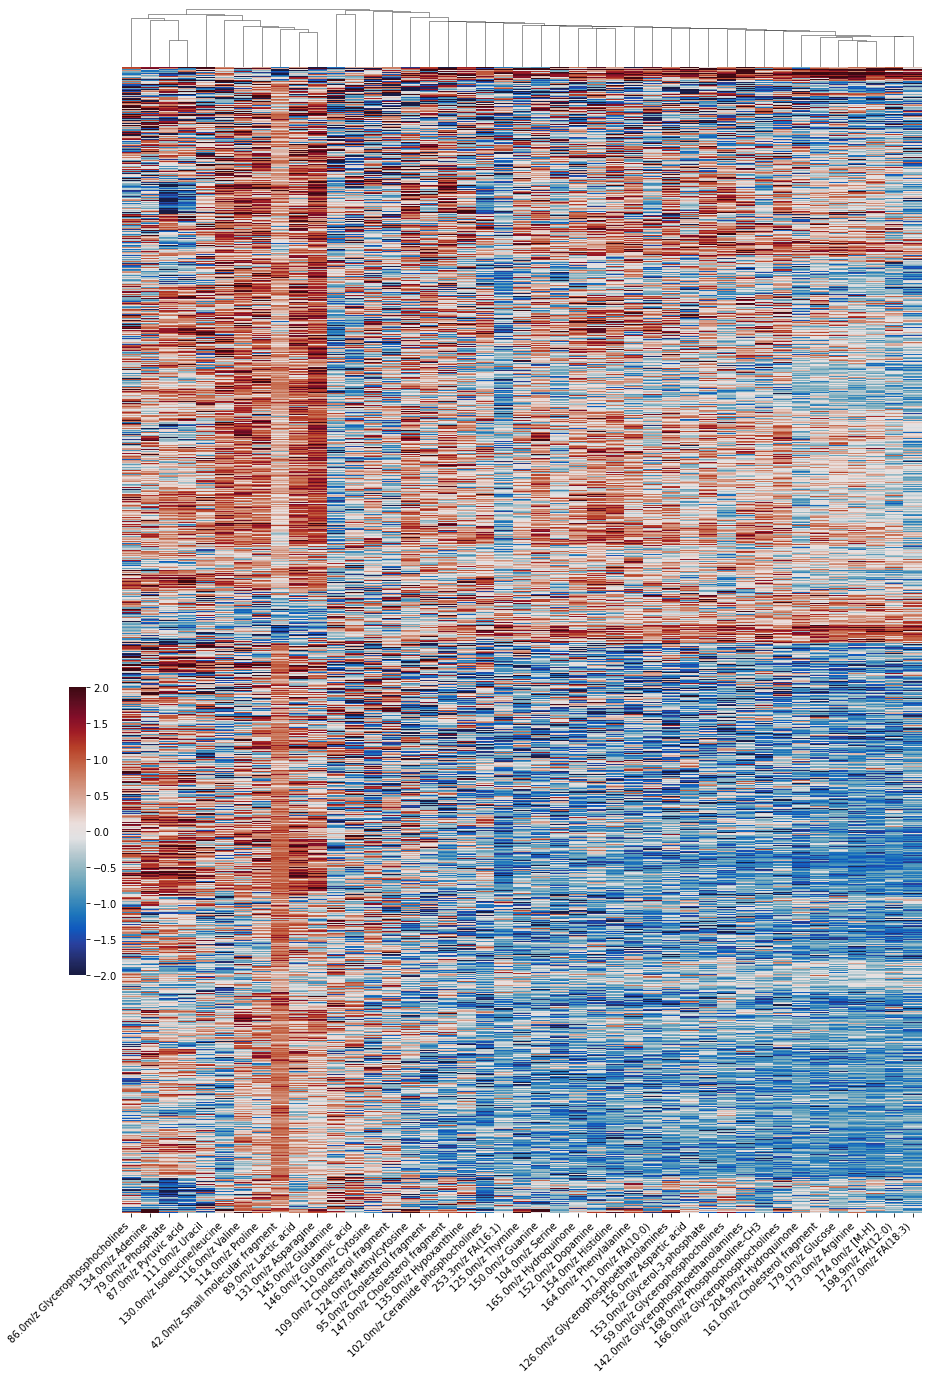

In [63]:
from matplotlib.colors import LogNorm
from matplotlib.pyplot import gcf

g = sns.clustermap(df_SIMS,
                   cmap=heatmap_cmp,
                   row_cluster=True,
                   col_cluster=True,
                   colors_ratio = (0.015, 0.01),
                   cbar_pos=(.0, .32, .02, .2), 
                   dendrogram_ratio=(.05, .05), 
                   figsize=(12, 20), 
                   yticklabels=False, 
                   xticklabels=True, 
                   vmax=2,
                   vmin=-2)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
g.ax_row_dendrogram.set_visible(False)

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right') 
plt.show()

In [64]:
sc.pp.neighbors(adata_SIMS, metric='cosine')
sc.tl.umap(adata_SIMS)
sc.tl.leiden(adata_SIMS, resolution=0.7, key_added='cluster')


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
running Leiden clustering
    finished: found 6 clusters and added
    'cluster', the cluster labels (adata.obs, categorical) (0:00:00)


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`


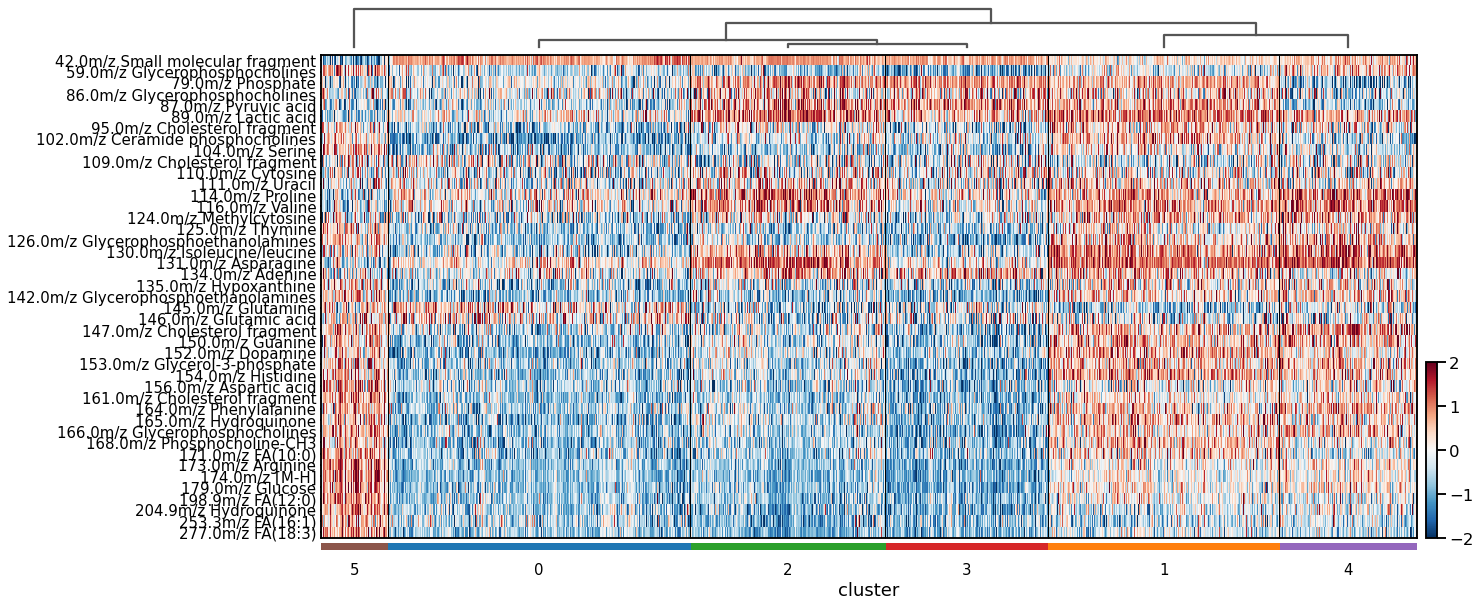

In [65]:
sc.tl.dendrogram(adata_SIMS, groupby='cluster')

with sns.plotting_context("talk", font_scale=1.):
    sc.pl.heatmap(
        adata_SIMS,
        adata_SIMS.var_names.tolist(),
        "cluster",
        dendrogram=True,
        cmap="RdBu_r",
        swap_axes=True, 
        figsize=(20,10),
        vmin=-2,
        vmax=2
    )

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


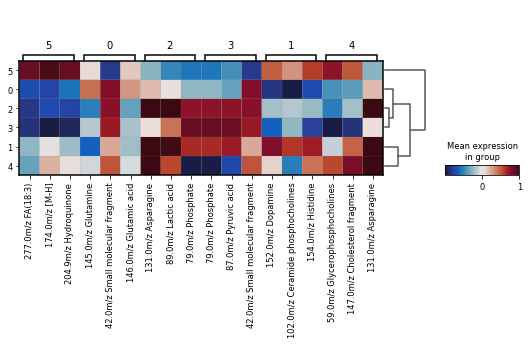

In [67]:
sc.tl.dendrogram(adata_SIMS, groupby='cluster')
sc.tl.rank_genes_groups(adata_SIMS, groupby='cluster', method='t-test')
sc.pl.rank_genes_groups_matrixplot(adata_SIMS, n_genes=3, use_raw=False, cmap=heatmap_cmp, vmax=1)

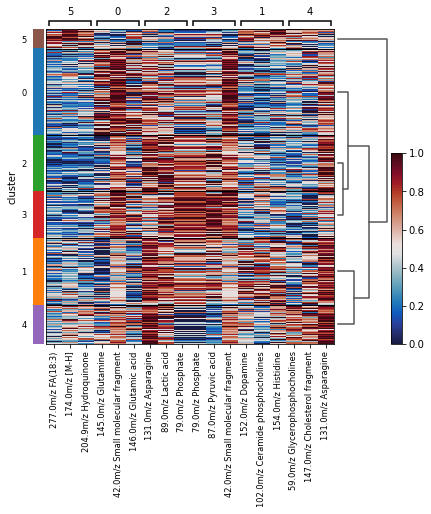

In [68]:
sc.pl.rank_genes_groups_heatmap(adata_SIMS,groupby='cluster',cmap=heatmap_cmp, standard_scale='obs', n_genes=3)
